In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lsst.daf.persistence as dp

In [2]:
butler = dp.Butler('/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/output')

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def read_tract(butler, tract, filter_='i', num_patches=None):
    if num_patches is None:
        num_patches = len(tract)
    df_list = []
    i = 0
    for patch in tract:
        patchId = '%d,%d' % patch.getIndex()
        dataId = dict(filter=filter_, tract=tract.getId(), patch=patchId)
        try:
            forced = butler.get('deepCoadd_forced_src', dataId)
            calib = butler.get('deepCoadd_calexp_calib', dataId)
            calib.setThrowOnNegativeFlux(False)
            merged = butler.get('deepCoadd_ref', dataId)
        except dp.NoResults as eobj:
            print(eobj)
            continue
        data = merged.asAstropy().to_pandas()
        data[filter_ + '_modelfit_CModel_flux'] = forced['modelfit_CModel_flux']
        data[filter_ + '_modelfit_CModel_fluxSigma'] = forced['modelfit_CModel_fluxSigma']
        data[filter_ + '_mag_CModel'] = calib.getMagnitude(forced['modelfit_CModel_flux'])
        data[filter_ + '_mag_err_CModel'] = calib.getMagnitude(forced['modelfit_CModel_fluxSigma'])
        data[filter_ + '_modelfit_CModel_SNR'] \
            = forced['modelfit_CModel_flux']/forced['modelfit_CModel_fluxSigma']
        data['ext_shapeHSM_HsmShapeRegauss_abs_e'] \
            = np.hypot(data['ext_shapeHSM_HsmShapeRegauss_e1'],
                       data['ext_shapeHSM_HsmShapeRegauss_e2'])
        print(i, patchId, len(data))
        df_list.append(data)
        i += 1
        if i == num_patches:
            break
    return pd.concat(df_list)

In [4]:
skymap = butler.get('deepCoadd_skyMap')
tractId = 4850
filter_ = 'i'
num_patches = None
data = read_tract(butler, skymap[tractId], filter_=filter_, num_patches=num_patches)
len(data)

0 0,0 19559
1 1,0 19286
2 2,0 16514
3 3,0 16028
4 4,0 15304
5 5,0 17023
6 6,0 18090
No locations for get: datasetType:deepCoadd_forced_src dataId:DataId(initialdata={'filter': 'i', 'tract': 4850, 'patch': '7,0'}, tag=set())
7 0,1 15882
8 1,1 15197
9 2,1 19162
10 3,1 17188
11 4,1 16914
12 5,1 18283
13 6,1 18555
No locations for get: datasetType:deepCoadd_forced_src dataId:DataId(initialdata={'filter': 'i', 'tract': 4850, 'patch': '7,1'}, tag=set())
14 0,2 18083
15 1,2 16223
16 2,2 15199
17 3,2 17378
18 4,2 17807
19 5,2 20840
20 6,2 15421
21 7,2 18754
22 0,3 18869
23 1,3 16101
24 2,3 19169
25 3,3 19680
26 4,3 17435
27 5,3 17944
28 6,3 18132
29 7,3 17105
30 0,4 20346
31 1,4 22248
32 2,4 16654
33 3,4 17649
34 4,4 19324
35 5,4 17298
36 6,4 18524
37 7,4 18250
38 0,5 15984
39 1,5 19885
40 2,5 17180
41 3,5 17326
42 4,5 18597
43 5,5 17612
44 6,5 20534
45 7,5 19189
46 0,6 20262
47 1,6 20569
48 2,6 16392
49 3,6 18537
50 4,6 16572
51 5,6 18357
52 6,6 19765
53 7,6 18061
54 0,7 17816
55 1,7 17157
56

1115542

In [5]:
base_mask = ~(np.isnan(data['i_modelfit_CModel_flux'])
         | np.isnan(data['ext_shapeHSM_HsmShapeRegauss_resolution'])
         | np.isnan(data['ext_shapeHSM_HsmShapeRegauss_e1']))
data = data[base_mask]
len(data)

590958

In [6]:
mask = data['detect_isPrimary']
mask &= data['deblend_skipped'] == False
mask &= data['base_PixelFlags_flag_edge'] == False
mask &= data['base_PixelFlags_flag_interpolatedCenter'] == False
mask &= data['base_PixelFlags_flag_saturatedCenter'] == False
mask &= data['base_PixelFlags_flag_crCenter'] == False
mask &= data['base_PixelFlags_flag_bad'] == False
mask &= data['base_PixelFlags_flag_suspectCenter'] == False
mask &= data['base_PixelFlags_flag_clipped'] == False
mask &= data['ext_shapeHSM_HsmShapeRegauss_flag'] == False

# Cut on object properties
mask &= data['i_modelfit_CModel_SNR'] >= 10
mask &= data['ext_shapeHSM_HsmShapeRegauss_resolution'] >= 0.3
mask &= data['ext_shapeHSM_HsmShapeRegauss_abs_e'] < 2
mask &= data['ext_shapeHSM_HsmShapeRegauss_sigma'] <= 0.4
mask &= data['i_mag_CModel'] < 24.5 # !!! Doesnt have exinction correction
mask &= data['base_Blendedness_abs_flux'] < 10**(-0.375)

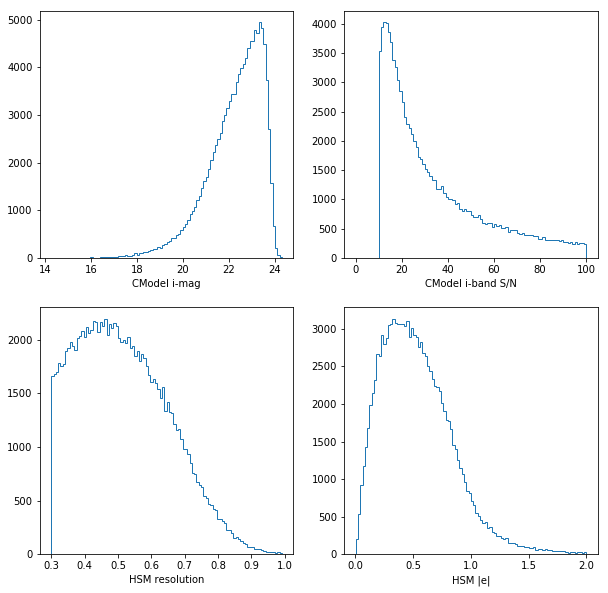

In [7]:
fig = plt.figure(figsize=(10, 10))
p1 = fig.add_subplot(2, 2, 1)
hist_kwds = dict(bins=100, histtype='step')
plt.hist(data['i_mag_CModel'][mask], **hist_kwds);
plt.xlabel('CModel i-mag')
p2 = fig.add_subplot(2, 2, 2)
plt.hist(data['i_modelfit_CModel_SNR'][mask], range=(0, 100), **hist_kwds);
plt.xlabel('CModel i-band S/N')
p3 = fig.add_subplot(2, 2, 3)
plt.hist(data['ext_shapeHSM_HsmShapeRegauss_resolution'][mask], **hist_kwds);
plt.xlabel('HSM resolution')
p4 = fig.add_subplot(2, 2, 4)
plt.hist(data['ext_shapeHSM_HsmShapeRegauss_abs_e'][mask], **hist_kwds);
plt.xlabel('HSM |e|');